In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm
from simulation.cl_simulation import ComplexLangevinSimulation
from simulation.gpu_handler import GPU_handler
from src.numba_target import use_cuda

def run_simulation(config, n_steps = int(1e4)):
    # define simulation parameters

    sim = ComplexLangevinSimulation(config)
    if use_cuda: 
        gpu_handler = GPU_handler(sim)
        gpu_handler.to_device()

    # register observable
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_params={'order': 1}, langevin_history=False)

    # start the loop 
    for _ in tqdm(range(n_steps)):
        sim.step()
        sim.compute('1_moment')

    sim.finish()
    if use_cuda: gpu_handler.to_host()

    return sim

Using Numba
Using double precision
Using C^1


/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/home/fhelmberger/miniconda3/envs/cle_cuda/lib/python3.10/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [6]:
sim.result['1_moment'].size

5000

100%|██████████| 50000/50000 [00:03<00:00, 14066.66it/s]


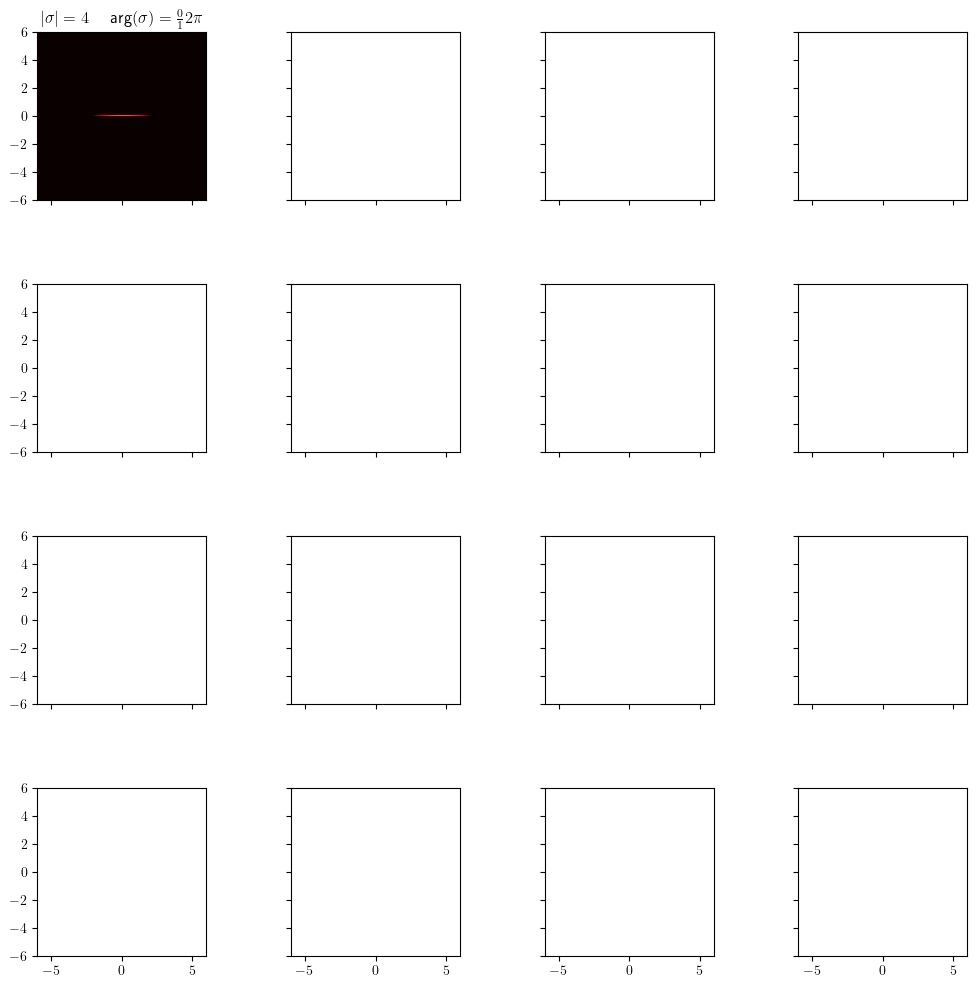

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from simulation.config import Config
plt.rcParams['text.usetex'] = True

ineraction = 12
sigma_abs = 4
num = 1
angle_start = 0
angle_end = np.pi*2

fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots


for idx in np.arange(num):
    angle = angle_start + (angle_end - angle_start) * idx / num
    mass = sigma_abs * (np.cos(angle) + 1j*np.sin(angle))
    label = rf"$|\sigma|={{{sigma_abs}}}$ \quad arg$(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"

    config = Config(dims = [1], trajs = int(5e2), mass_real = mass, interaction=12, dt = 5e-2)
    sim = run_simulation(config, n_steps=int(5e4))

    data = sim.trackers['1_moment'].history.flatten()
    magnitudes = np.abs(data)
    data = data[magnitudes <= 20]   
    art_dp = 10+10j
    data = np.append([art_dp, -art_dp], data)
    real_parts, imag_parts = data.real, data.imag
    bins = 500
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    ax = axes[idx]
    # Plot the heatmap
    ax.imshow(
        np.log10(heatmap+1).T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )

    ax.set_title(label)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    del sim
plt.show()